In [ ]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

from aind_vr_foraging_analysis.utils.plotting import general_plotting_utils as plotting, plotting_friction_experiment as f
from aind_vr_foraging_analysis.utils.parsing import parse, AddExtraColumns, data_access

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='yellow'

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = r'Z:\scratch\vr-foraging\data'
data_path = r'../../data/'
results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\experiments'

import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [ ]:
def speed_interpatch_odorsite(sum_df):
    mouse = sum_df['mouse'].unique()[0]
    
    # Filter to relevant labels
    df_filtered = sum_df[sum_df['label'].isin(['OdorSite', 'InterPatch'])]

    # Pivot so each row is a session with both OdorSite and InterPatch speeds
    pivot_df = df_filtered.pivot_table(index=['mouse', 'session_n', 'session'],
                                        columns='label',
                                        values='speed',
                                        aggfunc='mean').reset_index()

    # Drop any rows missing values
    pivot_df = pivot_df.dropna(subset=['OdorSite', 'InterPatch'])

    # Sort by session_n
    pivot_df = pivot_df.sort_values(by='session_n')

    # Set up colormap
    norm = mcolors.Normalize(vmin=pivot_df['session_n'].min(), vmax=pivot_df['session_n'].max())
    cmap = cm.get_cmap('viridis')
    colors = cmap(norm(pivot_df['session_n']))

    # Plot
    fig = plt.figure(figsize=(6, 5))

    # Draw line
    plt.plot(pivot_df['OdorSite'], pivot_df['InterPatch'], color='lightgray', linewidth=2, zorder=1)

    # Scatter with color
    sc = plt.scatter(pivot_df['OdorSite'], pivot_df['InterPatch'],
                    c=pivot_df['session_n'], cmap='viridis', s=40,  zorder=2)

    # Add session number labels
    for _, row in pivot_df.iterrows():
        plt.text(row['OdorSite']+0.2, row['InterPatch']+0.2, str(row['session_n']),
                fontsize=8, ha='right', va='bottom', color='black')

    plt.plot([-2, 40], [-2, 40], 'k--', linewidth=1.5, label='y=x', zorder=0)
    plt.xlim(-2, 40)
    plt.ylim(-2, 40)
    plt.xlabel("OdorSite Speed")
    plt.ylabel("InterPatch Speed")
    plt.colorbar(sc, label="Session Number")
    plt.grid(True)
    sns.despine()
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(foraging_figures, f'{mouse}_speed_interpatch_odorsite.pdf'), dpi=300, bbox_inches='tight')


In [ ]:
def grid_session_speed(df):
    # Filter out zero speeds
    # df = df[df.speed != 0]
    mouse = df.mouse.unique()[0]
    # Get all sessions for this mouse
    session_ns = sorted(df['session_n'].unique())
    n_sessions = len(session_ns)

    # Determine subplot grid size
    n_cols = int(np.ceil(np.sqrt(n_sessions)))
    n_rows = int(np.ceil(n_sessions / n_cols))

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), squeeze=False)

    for idx, sn in enumerate(session_ns):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]

        df_sn = df[(df.session_n == sn)]

        # InterSite
        sns.histplot(df_sn[df_sn.label == 'InterSite']['speed'],
                    bins=np.arange(-10,65,2), color='gray', alpha=0.7, stat='probability',
                    element='step', ax=ax, label='InterSite')

        # OdorSite
        sns.histplot(df_sn[df_sn.label == 'OdorSite']['speed'],
                    bins=np.arange(-10,65,2), alpha=0.5, stat='probability',
                    element='step', ax=ax, label='OdorSite')

        # InterPatch
        sns.histplot(df_sn[df_sn.label == 'InterPatch']['speed'],
                    bins=np.arange(-10,65,2), color='orange', alpha=0.7, stat='probability',
                    element='step', ax=ax, label='InterPatch')

        ax.set_title(f"Session {sn}")
        ax.set_xlabel("Speed (cm/s)")
        ax.set_ylabel("Density")
        
    plt.legend(loc='upper right')
    # Remove unused axes if grid is larger than number of sessions
    for j in range(len(session_ns), n_rows * n_cols):
        fig.delaxes(axes[j // n_cols][j % n_cols])

    sns.despine()
    fig.suptitle(f"Speed Distributions — Mouse {mouse}", fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    fig.savefig(os.path.join(foraging_figures, f'{mouse}_grid_session_speed_epochs.pdf'), dpi=300, bbox_inches='tight')



In [ ]:
def engaged_column(all_epochs: pd.DataFrame, window: int = 10, threshold: int = 10) -> pd.DataFrame:
    """
    Add an 'engaged' column to the DataFrame based on the specified conditions.

    Parameters:
    all_epochs (pd.DataFrame): The DataFrame containing the data.

    Returns:
    None: The function modifies the DataFrame in place.
    """
    
    # Filter only the OdorSite rows
    odor_df = all_epochs[all_epochs['label'] == 'OdorSite'].copy()

    # Condition: is_choice == 0 and site_number == 0
    odor_mask = (odor_df['is_choice'] == 0) & (odor_df['site_number'] == 0)

    # Rolling sum over OdorSite rows only
    odor_rolling = odor_mask.rolling(window=window, min_periods=window).sum()

    # Find the first index where 10 OdorSite rows in a row match
    odor_cut_idx = odor_rolling[odor_rolling == threshold].index.min()

    # Create the 'engaged' column, default to 1
    all_epochs['engaged'] = 1

    # If cutoff found, set engaged = 0 from that row forward
    if pd.notna(odor_cut_idx):
        # Find position in the original DataFrame
        disengage_start_pos = all_epochs.index.get_loc(odor_cut_idx)
        
        # Set engaged = 0 for all rows from this index onward
        all_epochs.loc[all_epochs.index[disengage_start_pos]:, 'engaged'] = 0
        
    return all_epochs

In [ ]:
date_string = "2024-8-24"
date = parse.parse_user_date(date_string)

In [ ]:
mouse_list = ['754579','754567','754580','754559','754560','754577','754566','754570','754571','754572','754573','754574','754575', '754582','745302','745305','745301']

In [ ]:
for mouse in mouse_list:
    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))
    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=False)
    
    sum_df = pd.DataFrame()
    df = pd.DataFrame()

    session_n = 0
    # All this segment is to find the correct session without having the specific path
    for file_name in sorted_files:
        
        session = parse.extract_and_convert_time(file_name)
        if session <= date:
            continue
        else:
            print(str(session), file_name)
            
        # Recover data streams
        session_path = os.path.join(base_path, mouse, file_name)
        session_path = Path(session_path)
        
        try:
            data = parse.load_session_data(session_path)
        except:
            continue
        stage = data['config'].streams.tasklogic_input.data['stage_name']
        # Parse data into a dataframe with the main features
        all_epochs = parse.parse_dataframe(data)
        all_epochs['epoch_duration'] = all_epochs['stop_time'] - all_epochs.index
        all_epochs['epoch_number'] = np.arange(len(all_epochs))
        
        if 'OdorSite' not in all_epochs['label'].unique():
            print('OdorSite not in this session')
            continue

        # Remove disengaged trials
        all_epochs = engaged_column(all_epochs, threshold=5)
        all_epochs = all_epochs[all_epochs['engaged'] == 1]
        
        encoder_data = parse.ContinuousData(data).encoder_data
        
        velocity = plotting.trial_collection(all_epochs[['label', 'epoch_number', 'epoch_duration']], 
                                                encoder_data, 
                                                cropped_to_length='epoch')

        for label in ['InterSite', 'InterPatch', 'OdorSite']:
            # Ensure new_row is a DataFrame before concatenation
            new_row = pd.DataFrame([{
                'session': session,
                'mouse': mouse,
                'session_n': session_n,
                'label': label,
                'speed': velocity.loc[velocity.label == label, 'speed'].median()
            }])

            # Concatenate the new_row DataFrame with sum_df
            sum_df = pd.concat([sum_df, new_row], ignore_index=True)
        
        # velocity = velocity.groupby(['epoch_number', 'label']).speed.mean().reset_index()
        velocity['session'] = session
        velocity['mouse'] = mouse
        velocity['session_n'] = session_n
        df = pd.concat([df, velocity], ignore_index=True)

        # sns.histplot(velocity.loc[velocity.label == 'InterSite']['speed'], bins=30,  color='gray', alpha=0.7)
        # sns.histplot(velocity.loc[velocity.label == 'OdorSite']['speed'], bins=30,  alpha=0.7)
        # sns.histplot(velocity.loc[velocity.label == 'InterPatch']['speed'], bins=30,  alpha=0.7)
        # sns.despine()
        # plt.xlabel("Speed (cm/s)")
        # plt.ylabel("Count")
        # plt.show()
        
        # sns.lineplot(data=velocity, x='times', y='speed', hue='label', errorbar=None)
        # plt.show()
        
        session_n += 1

        if stage == 'control':
            break
        
    speed_interpatch_odorsite(sum_df)
    grid_session_speed(df)

## **Joint plots for leaving probability of reward**

In [54]:
# Recover and clean batch 4 dataset
summary_df = pd.read_csv(data_path + 'batch_4.csv')

summary_df = summary_df[summary_df['label'] == 'OdorSite']
summary_df = summary_df.loc[summary_df.experiment.isin(['friction', 'control', 'distance_long', 'distance_short', 'friction_low','friction_med', 'friction_high', 'distance_extra_long', 'distance_extra_short'])]
summary_df = summary_df.loc[summary_df['engaged'] == True]
## These mice are in the dataset but didn't perform the manipulation
summary_df = summary_df[(summary_df['mouse'] != 754573)&(summary_df['mouse'] != 754572)&(summary_df['mouse'] != 745300)&(summary_df['mouse'] != 745306)&(summary_df['mouse'] != 745307)]
summary_df.reset_index(inplace=True)
summary_df['time_between'] = summary_df.groupby(['mouse', 'session']).start_time.transform(lambda x: x.max() - x.min())

df = pd.read_csv(data_path + 'batch_3.csv')
# df = df.loc[(df.mouse != '713578')&(df.mouse != '715866')]
df = pd.concat([df, summary_df], ignore_index=True)

In [ ]:
df['odor_label'] = np.where(df['odor_label'] == 'Alpha pinene', 'Alpha-pinene', df['odor_label'] )
df['patch_label'] = np.where(df['patch_label'] == 'Alpha pinene', 'Alpha-pinene', df['patch_label'] )

In [ ]:
groups = ['session', 'session_n','mouse','patch_number','odor_label','experiment', 'rig']

#Relabelling the sessions using the torque calibration
# summary_df['experiment'] = summary_df['experiment_torque']

pre_df = df[(df['engaged'] == True)|(df['patch_number'] <= 20)]

# pre_df = pre_df.loc[(pre_df.mouse != 754577)&(pre_df.mouse != 754575)]
# These df summarizes each patch for each session for each mouse
mouse_df = (
    pre_df.loc[(pre_df.site_number > 0) & (pre_df.last_site == 1)]
    .groupby(groups)
    .agg(
        site_number=('site_number', 'max'),
        reward_probability=('reward_probability', 'min'),
        stops=('site_number', 'max'),
        total_rewards=('cumulative_rewards', 'max'),
        consecutive_rewards = ('consecutive_rewards', 'max'),
        total_failures=('cumulative_failures', 'max'),
        consecutive_failures = ('consecutive_failures', 'max'), 
        friction=('torque_friction', 'max'),
    )
    .reset_index()
)
mouse_df['total_water'] = mouse_df['total_rewards']*5
groups.pop(groups.index('patch_number'))

# These df summarizes each session for each mouse (averages patches within session)
session_df = ( 
        mouse_df
        .groupby(groups)
        .agg(site_number = ('site_number','sum'), 
              reward_probability = ('reward_probability','mean'), 
              stops = ('stops','mean'),
              total_stops = ('stops','sum'), 
              total_rewards = ('total_rewards','mean'),
              consecutive_rewards = ('consecutive_rewards','mean'),
              total_failures = ('total_failures','mean'),
              consecutive_failures = ('consecutive_failures','mean'), 
              patch_number = ('patch_number','nunique'), 
              total_water = ('total_water','sum'),
              friction = ('friction', 'mean'))
        .reset_index()
)

groups.pop(groups.index('session_n'))
# groups.pop(groups.index('within_session_n'))

# These df summarizes metrics for each mouse (averages all sessions and all patches withing that session)
general_df = ( 
        mouse_df
        .groupby(['mouse','odor_label', 'experiment'])
        .agg({'site_number':'mean', 
              'reward_probability':'mean', 
              'stops':'mean', 
              'total_rewards':'mean',
              'consecutive_rewards':'mean',
              'total_failures':'mean',
              'consecutive_failures':'mean', 
              'patch_number':'mean'
              })
        .reset_index()
)

In [ ]:
for experiment in summary_df.experiment.unique():
    with PdfPages(results_path+f'/summary_results_{experiment}_per_mouse.pdf') as pdf:
        for mouse in session_df.mouse.unique():
            print(mouse)
            f.summary_main_variables(session_df.loc[session_df.mouse == mouse], experiment, condition='session_n', save=pdf, odor_labels=df.odor_label.unique())

In [ ]:
for experiment in general_df.experiment.unique():
    with PdfPages(results_path+f'/summary_general_results_{experiment}_all.pdf') as pdf:
        f.summary_main_variables(general_df, experiment, condition='mouse', save=pdf)

### Correlation of p(reward) with time

- Ask chatgpt how to better group things

In [55]:
summary = df.loc[(df.is_choice ==True)].groupby(['session','mouse','patch_number','odor_label', 'environment','experiment']).agg({'collected':'sum','site_number':'count', 'reward_probability':'min'}).reset_index()
# summary = summary.loc[(summary.site_number > 1)]
summary = summary.loc[((summary.site_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
summary = summary.groupby(['session','mouse','odor_label', 'environment','experiment']).agg({'collected':'mean','reward_probability':'mean', 'patch_number': 'nunique'}).reset_index()
summary = summary.loc[summary.patch_number >= 10]
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

summary = summary.groupby(['mouse','odor_label' , 'experiment', 'environment'])['reward_probability'].mean().reset_index()
summary = summary.loc[summary.experiment == 'base']
summary = summary.groupby('mouse').agg({'reward_probability':'mean'}).reset_index()

Correlation coefficient (pandas): -0.5370265731007936
Correlation coefficient (scipy): -0.5370265731007936
P-value: 0.08848343172249318


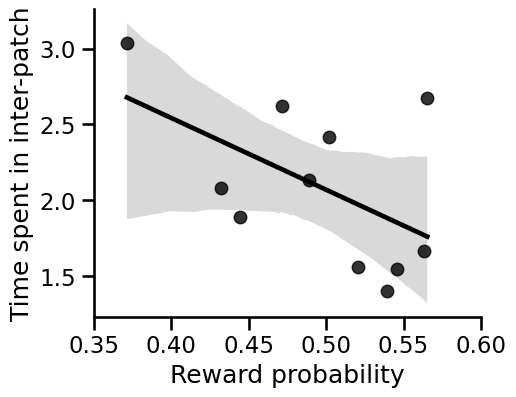

In [ ]:
from scipy.stats import pearsonr, ttest_rel

summary['duration_epoch'] = df.loc[df.experiment == 'base'].groupby(['mouse']).duration_epoch.median().reset_index()['duration_epoch']

# Assuming summary DataFrame is already defined
# Calculate the correlation coefficient using pandas
correlation_matrix = summary[['reward_probability', 'duration_epoch']].corr()
correlation_coefficient = correlation_matrix.loc['reward_probability', 'duration_epoch']
print(f"Correlation coefficient (pandas): {correlation_coefficient}")

# Calculate the correlation coefficient and p-value using scipy
correlation_coefficient, p_value = pearsonr(summary['reward_probability'], summary['duration_epoch'])
print(f"Correlation coefficient (scipy): {correlation_coefficient}")
print(f"P-value: {p_value}")

fig = plt.figure(figsize=(5, 4))
# Plot the regression plot
sns.regplot(data=summary, x='reward_probability', y='duration_epoch', color='black')
# plt.text(0.55, 5.5, f"r = {correlation_coefficient:.3f}\np = {p_value:.3f}", ha='center', va='center')
plt.xlabel('Reward probability')
plt.ylabel('Time spent in inter-patch')
plt.xlim(0.35, 0.6)
sns.despine()
# fig.savefig(results_path+'/duration_epoch_vs_reward_probability.svg', dpi=300, bbox_inches='tight')

In [65]:
# Identify rows with 'PostPatch' label
postpatch_indices = summary_df[summary_df['label'] == 'PostPatch'].index

# Add duration_epoch values for 'PostPatch' and their following row
summary_df['duration_epoch_postpatch'] = 0  # Initialize new column
for idx in postpatch_indices:
    if idx + 1 < len(summary_df):  # Ensure not to exceed DataFrame bounds
        print(summary_df.loc[idx, 'session'], summary_df.loc[idx+1, 'session'])
        summary_df.loc[idx, 'duration_epoch'] = summary_df.loc[idx, 'duration_epoch'] + summary_df.loc[idx + 1, 'duration_epoch']
        summary_df.loc[idx + 1, 'label'] = 'accounted'  # Update label to 'PostPatch'
        summary_df.loc[idx, 'label'] = 'InterPatch'
    else:
        
        print('wrong')
        summary_df.loc[idx, 'duration_epoch'] = summary_df.loc[idx, 'duration_epoch']
        
summary_df = summary_df[summary_df['duration_epoch'] <= 500]

In [66]:
test_df = summary_df.copy()
test_df.set_index('start_time', inplace=True)
test_df = test_df.loc[test_df['label'] == 'InterPatch']
test_df = test_df.groupby(['mouse', 'experiment', 'session_n'])['duration_epoch'].mean().reset_index()

In [69]:
summary = summary_df.loc[(summary_df.is_choice ==True)].groupby(['session','mouse','patch_number','odor_label', 'experiment']).agg({'collected':'sum','site_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[(summary.site_number > 1)]
summary = summary.groupby(['session','mouse','odor_label', 'experiment']).agg({'collected':'mean','reward_probability':'mean', 'patch_number': 'nunique'}).reset_index()
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

summary = summary.groupby(['mouse','odor_label' , 'experiment'])['reward_probability'].mean().reset_index()
summary = summary.loc[summary.experiment == 'data_collection']
test_df = summary.groupby('mouse').agg({'reward_probability':'mean'}).reset_index()

In [70]:
df = test_df.groupby(['mouse','session_n']).duration_epoch.median().reset_index()
fig = plt.figure(figsize=(12, 22))
for i, mouse in enumerate(df.mouse.unique()):
    ax = fig.add_subplot(6, 3, i+1)
    sns.lineplot(data=df.loc[df.mouse == mouse], x='session_n', y='duration_epoch', markers=True)
    plt.title(mouse)
    sns.despine()
    plt.ylim(0,20)
plt.tight_layout()
plt.show()

KeyError: 'session_n'